<a href="https://colab.research.google.com/github/a01634928/TC3006C_101_A01634928/blob/main/modulo_2/Implementacion_de_una_tecnica_de_aprendizaje_maquina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de predicción sobre pedidos recibidos a repartidores de app delivery
### El objetivo es predecir si el repartidor acepto o no la solicitud de pedido.
Autor: Jesús David Núñez Rodríguez A01634928  
Variables:  
-order_id= Descripción: Id de la orden, Tipo de variable: cuantitativa discreta  
-store_id= Descripción: Id de establecimiento, Tipo de variable: cuantitativa discreta  
-to_user_distance= Descripción: Distancia recorrerá el repartidor para completar el pedido, Tipo de variable: cuantitativa continua  
-to_user_elevation= Descripción: Elevación positiva o negativa del repartidor a la ubicación del pedido, Tipo de variable: cuantitativa
continua  
-total_earning= Descripción: Ganancia neta del repartidor, Tipo de variable: cuantitativa continua  
-created_at= Descripción: Fecha del pedido, Tipo de variable: cualitativa ordinal  
-taken= Descripción: Si se acepto o no el pedido(binario 1 acepto, 0 rechazo), Tipo de variable: cuantitativa discreta


In [ ]:
#Librerias necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from math import e,log
from scipy import stats
from scipy.stats import skew
from scipy.stats import kurtosis
%matplotlib inline

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AaTecM/semestre_7mo/septimo/reto1/input/Libro1.csv', nrows= 5000)
df

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,created_at,taken
0,14364873,30000009,2.478101,-72.719360,4200,2017-09-07T20:02:17Z,0
1,14370123,30000058,0.451711,37.754761,4200,2017-09-07T20:13:16Z,0
2,14368534,900003684,2.026072,207.191162,4000,2017-09-07T20:07:23Z,0
3,14370258,900014452,2.671432,1.722656,4400,2017-09-07T20:15:19Z,1
4,14369923,900014085,0.965496,117.429199,3450,2017-09-07T20:12:14Z,1
...,...,...,...,...,...,...,...
4995,15255745,900007718,2.880413,-11.715576,6650,2017-09-23T16:50:57Z,1
4996,15255736,900002516,1.438965,171.192993,4200,2017-09-23T16:50:57Z,1
4997,15255747,900014085,2.047149,71.333130,4750,2017-09-23T16:50:57Z,1
4998,15255849,900008201,0.402239,-3.296021,3200,2017-09-23T16:51:59Z,1


# Exploración y prepocesamiento de los datos 

In [ ]:
#Validar tipo de dato y si hay valores nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   order_id           5000 non-null   int64  
 1   store_id           5000 non-null   int64  
 2   to_user_distance   5000 non-null   float64
 3   to_user_elevation  5000 non-null   float64
 4   total_earning      5000 non-null   int64  
 5   created_at         5000 non-null   object 
 6   taken              5000 non-null   int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 273.6+ KB


Se valida que efectivamente no hay valores nulos en el dataframe

In [ ]:
#Creación de atributo para saber hora del día en que realizó el pedido y en que
#día de la semana
df['created_at'] = df['created_at'].astype('datetime64[ns]')
df['hour_order']= df.created_at.dt.hour
df['weekday_order']= df.created_at.dt.day_name()
df

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,created_at,taken,hour_order,weekday_order
0,14364873,30000009,2.478101,-72.719360,4200,2017-09-07 20:02:17,0,20,Thursday
1,14370123,30000058,0.451711,37.754761,4200,2017-09-07 20:13:16,0,20,Thursday
2,14368534,900003684,2.026072,207.191162,4000,2017-09-07 20:07:23,0,20,Thursday
3,14370258,900014452,2.671432,1.722656,4400,2017-09-07 20:15:19,1,20,Thursday
4,14369923,900014085,0.965496,117.429199,3450,2017-09-07 20:12:14,1,20,Thursday
...,...,...,...,...,...,...,...,...,...
4995,15255745,900007718,2.880413,-11.715576,6650,2017-09-23 16:50:57,1,16,Saturday
4996,15255736,900002516,1.438965,171.192993,4200,2017-09-23 16:50:57,1,16,Saturday
4997,15255747,900014085,2.047149,71.333130,4750,2017-09-23 16:50:57,1,16,Saturday
4998,15255849,900008201,0.402239,-3.296021,3200,2017-09-23 16:51:59,1,16,Saturday


In [ ]:
#Inspeccionar quantiles, mediana y desviación estandar.
df.describe()

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,taken,hour_order
count,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.507434e+07,7.604182e+08,1.500403,24.962399,5332.181200,0.906400,15.793400
std,4.450853e+05,3.192913e+08,0.849172,86.172319,1776.446375,0.291301,3.959779
min,1.425905e+07,3.000000e+07,0.046133,-569.226196,3000.000000,0.000000,0.000000
25%,1.470556e+07,9.000046e+08,0.831520,-19.857056,4200.000000,1.000000,12.000000
50%,1.504261e+07,9.000077e+08,1.397507,9.560669,5200.000000,1.000000,16.000000
75%,1.546334e+07,9.000128e+08,2.022482,58.364868,6300.000000,1.000000,19.000000
max,1.588164e+07,9.000172e+08,9.078181,1009.380005,18500.000000,1.000000,23.000000


In [ ]:
# convertir a variable categorica numerica la columna weekday_order
number = LabelEncoder()
df['weekday_order'] = number.fit_transform(df['weekday_order'].astype('str'))

In [ ]:
#Eliminar columnnas que no son necesarias para gráficar scatterplot
df.drop(columns=['order_id','store_id','created_at'], inplace=True, axis=1)

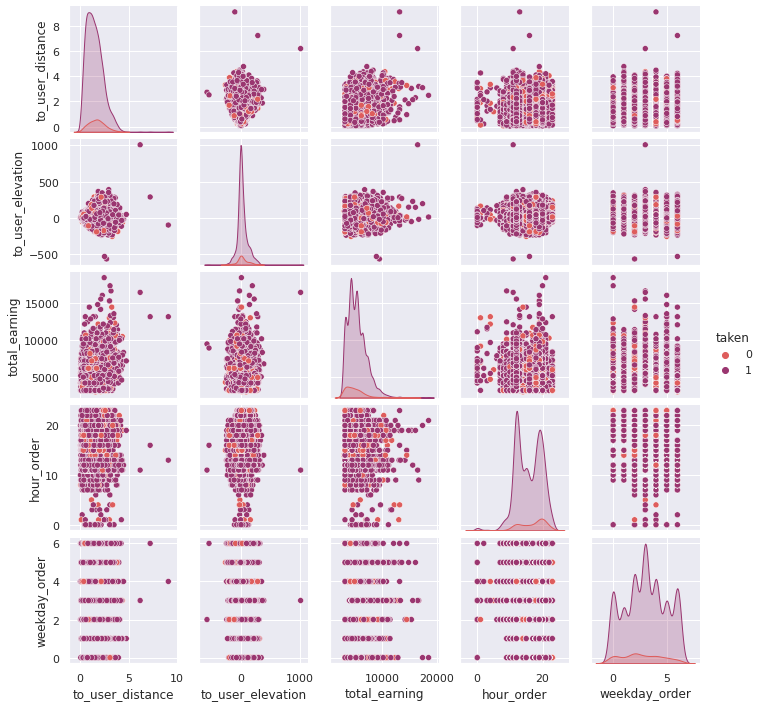

In [ ]:
sns.set()
sns.pairplot(df, hue='taken',height = 2, palette = 'flare')

En las gráficas podemos observar que hay datos atípicos, los cuales deben ser retirados para crear un modelo más preciso.

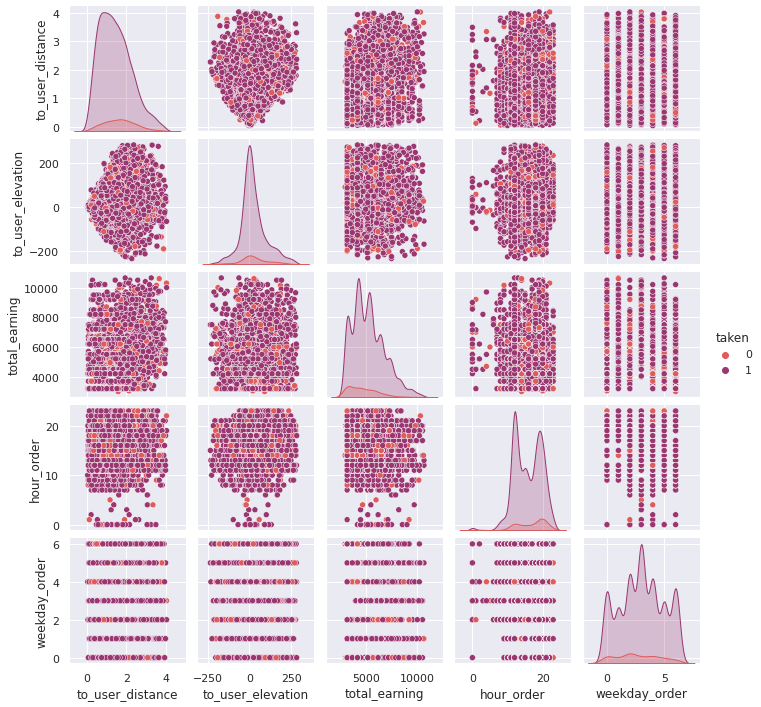

In [ ]:
# Se eliminan los datos atipicos de las columnas 'to_user_distance','to_user_elevation','total_earning'
df = df[(np.abs(stats.zscore(df[['to_user_distance','to_user_elevation','total_earning']])) < 3).all(axis=1)]
sns.set()
sns.pairplot(df, hue='taken',height = 2, palette = 'flare')

Ahora se puede observar que los datos están distribuidos de una manera más uniforme. A primera vista no se observa ningun patron relacionado a alguna de las variables, que sea util para categorizar si el repartidor aceptará o no el pedido. Por lo que se procederá a tomar una de las variables para probar su efectividad en un modelo de regresión logística.

Se seleccionó la variable to_user_distance para la cual se evaluará sesgo y curtosis.

Sesgo: 0.589827923578228
Curstosis: -0.13951830813533794


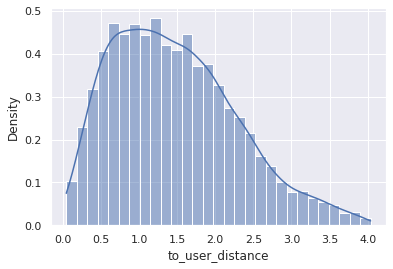

In [ ]:
#Validar sesgo y curtosis
sns.histplot(df['to_user_distance'], kde=True, stat="density")
print('Sesgo: ' + str(skew(df['to_user_distance'])))
print('Curstosis: ' + str(kurtosis(df['to_user_distance'])))

Graficamente se puede observar que hay sesgo positivo a la derecha. Sin embargo la curtosis se encuentra en un rango aceptable ya que está alejado del 0 menos de 0.5. 
Para disminuir el sesgo de los datos se realizará una transfomación de Box-Cox.

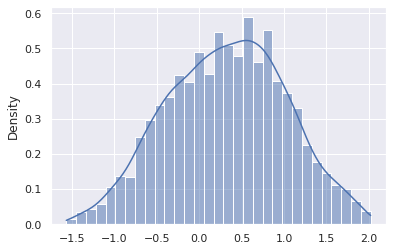

In [ ]:
#Transformación Box-Cox
fitted_data, fitted_lambda = stats.boxcox(df['to_user_distance']) 
sns.histplot(fitted_data, kde=True, stat="density")  

# Etapa de modelación 

In [ ]:
# Regresión lógistica de 1 orden
def orden1 (x_train,y_train,theta,alpha,h,j_i):
  n=len(y_train)
  for idx in range (1000):
    zDelta =[]
    zDeltaX=[]
    for x_i, y_i in zip (x_train,y_train):
      zDelta.append(h(x_i,theta)-y_i)
      zDeltaX.append ((h(x_i,theta)-y_i)*x_i)

    sJt0=sum(zDelta)
    sJt1=sum(zDeltaX)
    theta[0]= theta[0]-alpha/n*sJt0 
    theta[1]=theta[1]-alpha/n*sJt1
  print(theta)
  return theta

In [ ]:
def validate(X_train,y_train,X_test,y_test,theta):
  n_train = len(y_test)
  n_val = len(y_train)
  zDelta = []
  for x_i, y_i in zip(X_train,y_train):
    zDelta.append(j_i(x_i,y_i,theta))  
  sDelta = sum(zDelta)  
  J_validate = 1/(2*n_val)*sDelta

  # Entrenamiento
  zDelta = []
  for x_i, y_i in zip(X_test,y_test):
    zDelta.append(j_i(x_i,y_i,theta))  
  sDelta = sum(zDelta)  
  J_train = 1/(2*n_train)*sDelta

In [ ]:
X= df[["to_user_distance"]].to_numpy() #Variable independiente
y= df[["taken"]].to_numpy() #Variable dependiente

#Se dividen los datos para tener una sección que sirva para validar y otra que se usará para alimentar el modelo.
X, X_validacion, y, y_validacion = train_test_split(X,y,random_state=0, train_size= 0.9)

#Se dividen los datos para tener datos de entrenamiento y de pruebas
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0, train_size= 0.8)

In [ ]:
h   = lambda x,theta: 1/(1+e**(-(theta[0]+theta[1]*x))) #Función de hipótesis (orden 1)
j_i = lambda x,y,theta: y*log(h(x,theta),e) + (1-y)*log(1-h(x,theta),e) #Función de costo

print("Theta taken")
theta11=orden1(X_train,y_train,[1,1],0.1,h,j_i)
print("\n")
print("Validación taken")
validate(X_train,y_train,X_test,y_test,theta11)



Theta taken
[array([2.3471643]), array([-0.10238564])]


Validación taken


In [ ]:
#Obtención de precisión del modelo a partir de los datos de validación
arr = np.empty((1,2), int)
for x_i, y_i in zip (X_validacion,y_validacion):
      x0=float(x_i) 
      y0=int(y_i)
      prob= float(h(x0,theta11))
      pred = round(prob)
      arr = np.concatenate((arr, np.array([[pred,y0]])), axis=0)
arr_j = np.array(np.where(arr[:, 0]==arr[:, 1]))
accurate = (100/len(arr[:, 0]) * len(arr_j[0, :]))
print('Porcentaje de presición del modelo: ' + str(accurate) + '%')

Porcentaje de presición del modelo: 91.41104294478528%


# Pruebas de validación y conclusiones


In [ ]:
#Prueba aleatoria de que el pedido será aceptado para un dato en espécifico
print("Predicción pedido aceptado")
x0=float(X_validacion[4]) 
y0=int(y_validacion[4])
prob= float(h(x0,theta11))
pred = round(prob)
print("Valores de el dato de prueba: ",x0)
print("Probabilidad de que se acepte el pedido",prob)

print("taken predicción:",pred)
print('----------------')
print("Taken real: ",y0,"\n")

Predicción pedido aceptado
Valores de el dato de prueba:  0.623147063
Probabilidad por clase 0.9074897638268326
Clase predicción: 1
----------------
Clase real:  1 



In [ ]:
#Segunda prueba aleatoria de que el pedido será aceptado para un dato en espécifico
print("Predicción pedido aceptado")
x0=float(X_validacion[57])  
y0=int(y_validacion[57])
prob= float(h(x0,theta11))
pred = round(prob)
print("Valores de el dato de prueba: ", x0)
print("Probabilidad de que se acepte el pedido",prob)

print("Taken predicción:",pred)
print('----------------')
print("Taken real: ",y0,"\n")

Predicción pedido aceptado
Valores de el dato de prueba:  2.57529167
Probabilidad de que se acepte el pedido 0.8892882457619042
Taken predicción: 1
----------------
Taken real:  1 



In [ ]:
#Tercera prueba aleatoria de que el pedido será aceptado para un dato en espécifico
print("Predicción pedido aceptado")
x0=float(X_validacion[355])  
y0=int(y_validacion[355])
prob= float(h(x0,theta11))
pred = round(prob)
print("Valores de el dato de prueba: ",x0)
print("Probabilidad de que se acepte el pedido",prob)

print("Taken predicción:",pred)
print('----------------')
print("Taken real: ",y0,"\n")

Predicción pedido aceptado
Valores de el dato de prueba:  1.731365327
Probabilidad de que se acepte el pedido 0.8975135245220024
Taken predicción: 1
----------------
Taken real:  0 



**En conclusión** pese a que el porcentaje de precisión del modelo es superior al 90% el modelo no es tan confiable, ya que en las primeras dos pruebas fue correcto, pero en la tercerá falló la predicción.  
El modelo presenta problemas para detectar cuando repartidor no tomará la orden, lo cual apunta a un underfit del modelo. Debido a que no llega con exactitud a realizar una categorización de forma correcta.
Esto puede deberse a que en la base de datos utilizada no cuenta con tantos registros donde se haya rechazado el pedido.  
Por otro lado una segunda posibilidad que afecto al modelo es el de que los datos se encontraban mezclados por lo que hay un alto nivel de "ruido" en los datos.
Una tercera solución pudiera ser incrementar la complejidad del modelo para obtener mejores clusters.
En análisis futuros se utilizará otras variables u otros modelos de machine learning supervisados para clasificación. De esta forma se podría encontrar uno que mejore la confiabilidad de la predicción.